# 锚框

In [1]:
import torch
from torch import nn
import d2l.torch as d2l
import torchvision
import matplotlib.pyplot as plt

### 生成多个锚框

设缩放比 $s\in(0,1]$ , 宽高比 $r>0$ , 原图宽高 $W$ , $H$ , 锚框宽高 $w$ , $h$

$$
\dfrac{wh}{WH} = s^2 \ \ , \ \ \dfrac{w}{h} = r \\
$$
$$
\Rightarrow w = s * \sqrt{HWr} \\
\Rightarrow h = s * \sqrt{\dfrac{HW}{r}}
$$

然后对 $w$ , $h$ 进行归一化, 使用相对坐标来表示位置

$$
w_0 = \dfrac{w}{W} = s\sqrt{\dfrac{Hr}{W}}\\
h_0 = \dfrac{h}{H} = s\sqrt{\dfrac{W}{Hr}}
$$

这样生成一共会生成 $wh \times N_s N_r$ 个锚框, 但是在这里只考虑含有 $s1$ 和 $r1$ 的组合

In [2]:
def multibox_prior(data, sizes, ratios): # 输入图像, 缩放比(list), 宽高比(list)
    """
    以输入的shape :
    data (4, 4)
    sizes (3)
    ration (3)
    为例
    """
    H, W = data.shape[-2:] # (sample, channel, h, w)
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios) # 3, 3
    boxes_per_pixel = (num_sizes + num_ratios - 1) # 每个像素的锚框数, 也就是 s1 和 r1 的组合数
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # 生成锚框的所有中心点
    center_h = (torch.arange(H, device=device) + 0.5) / H
    center_w = (torch.arange(W, device=device) + 0.5) / W
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij') # index 为 ij 或者 xy 遍历顺序有所不同, 不过不影响
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    """
    按照 ij 生成的数据大概长这样, 这是归一化之后的数据
    tensor([[0.1250, 0.1250, 0.1250, 0.1250],
            [0.3750, 0.3750, 0.3750, 0.3750],
            [0.6250, 0.6250, 0.6250, 0.6250],
            [0.8750, 0.8750, 0.8750, 0.8750]])

    tensor([[0.1250, 0.3750, 0.6250, 0.8750],
            [0.1250, 0.3750, 0.6250, 0.8750],
            [0.1250, 0.3750, 0.6250, 0.8750],
            [0.1250, 0.3750, 0.6250, 0.8750]])
    """
    w0 = torch.cat((sizes[0] * torch.sqrt(H * ratio_tensor[:] / W), size_tensor[1:] * torch.sqrt(H * ratio_tensor[0] / W)))
    h0 = torch.cat((sizes[0] * torch.sqrt(W / ratio_tensor[:] / W), size_tensor[1:] * torch.sqrt(H / ratio_tensor[0] / W)))
    # 除 2 来获得半高和半宽
    """
    w0 h0 的 shape 是 [box_per_pixel]
    torch.stack((-w0, -h0, w0, h0)) shape 为 [4,5] , 5 是 box_per_pixel, 所以需要转置一下, 将 "sample" 放在前面去 shape 变成 [5,4]
    因为这个计算的是一个像素在一个点的 w0 h0 , 每个像素都需要一个这样的锚框, 所以重复 H * W 次
    torch 的 reshape 函数保持了原来的 dim 不变, 再进行复制
    anchor_manipulations 的 shape 为 [80,4]
    """
    anchor_manipulations = torch.stack((-w0, -h0, w0, h0)).T.repeat(H * W, 1) / 2
    """
    repeat_interleve 按照维度进行复制, 这个复制是每一个元素单独复制, repeat 是看作一个整体之后再进行复制
    shift_x, shift_y, shift_x, shift_y 和 -w0, -h0, w0, h0 对应, 相加减之后就能得到左下角和右上角的坐标
    torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1) shape 为 [16, 4]
    repeat 之后 shape 为 [80, 4]
    """
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    """
    区别
    a = [1, 2, 3, 4]
    repeat_interleave 2: 
    a = [1, 1, 2, 2, 3, 3, 4, 4]
    repeat 2:
    a = [1, 2, 3, 4, 1, 2, 3, 4]
    """
    output = out_grid + anchor_manipulations
    """ 插入一维, 不增加任何数据, 从 (80, 4) 变成 (1, 80, 4) """
    return output.unsqueeze(0)


测试一下

In [3]:
img = torchvision.io.read_image('img/catdog.jpg').unsqueeze(0)
print(f'the shape of img is {img.shape}')
Y = multibox_prior(img, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
print(f'shape of Y is {Y.shape}')

the shape of img is torch.Size([1, 3, 561, 728])
shape of Y is torch.Size([1, 2042040, 4])


现在可以非常方便的通过 $x$ , $y$ 进行访问

In [4]:
h, w = img.shape[-2:]
boxes = Y.reshape(h, w, 5, 4)
print(boxes.shape)

torch.Size([561, 728, 5, 4])


绘制多个边框的函数

In [5]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = obj
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i%len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(
                rect.xy[0], rect.xy[1], labels[i],
                va='center', ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0)
            )

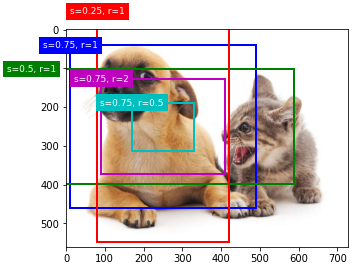

In [6]:
bbox_scale = torch.tensor((w, h, w, h))
fig = plt.imshow(img.squeeze(0).permute(1, 2, 0))
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2','s=0.75, r=0.5'])

# 交并比 IoU

目标界框和真实边界框如何匹配量化, 就可以使用交并比来进行衡量

$$
J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}
$$

![img](https://zh-v2.d2l.ai/_images/iou.svg)

计算 iou

In [7]:
def box_iou(boxes1, boxes2): # (sample, xy)
    box_area = lambda boxes : ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])) # 一个用于计算面积的函数
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    """
    None 是插入一维
    x[:, :2] : shape (3, 2) 
    tensor([[0, 1],
            [4, 5],
            [8, 9]])
    
    x[:, None, :2] : shape (3, 1, 2)
    tensor([[[0, 1]],
            [[4, 5]],
            [[8, 9]]])
    
    求 max : shape (3, 3, 2)
    tensor([[[0, 1],
             [4, 5],
             [8, 9]],
            [[4, 5],
             [4, 5],
             [8, 9]],
            [[8, 9],
             [8, 9],
             [8, 9]]])
    先将 (3, 1, 2)  广播为 (3, 3, 2)
    再把 (3, 2) 广播为 (3, 3, 2)
    """
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2]) # 左下角坐标取一个最大的 
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:]) # 右上角坐标取一个最小的
    
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0) # clamp 约束值在 min 到 max 之间
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

将真实的边界框分配给锚框

In [8]:
def assign_anchor_to_bbox(ground_truth, anchors, device, ios_threshold=0.5):
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    jaccard = box_iou(anchors, ground_truth)
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device) # 创建一个 (num_anchors,) 全-1 的数组
    max_ious, indices = torch.max(jaccard, dim=1) # 每行最大值, 最大值坐标
    """
    nonezero 返回不为 0 的数的下标, 因为 max_ious 是一维的, 所以 anc_i 也是一维的
    再放入一个 True/False 的条件
    """
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1) # anc_i 是 max_ious 中大于 0.5 的坐标
    box_j = indices[max_ious >= 0.5] # box_j 是 jaccard>=0.5 的最大值坐标 
    anchors_bbox_map[anc_i] = box_j # 把大于阈值的全部分配给真实边界框
    """
    举个例子 
    jaccard : 
    tensor([[0.3323, 0.0536, 0.3025],
            [0.3395, 0.6187, 0.3303],
            [0.7496, 0.7910, 0.1856],
            [0.5927, 0.0220, 0.7873]])
    
    max_ious : 
    tensor([0.3323, 0.6187, 0.7910, 0.7873])

    indices : 
    tensor([0, 1, 1, 2])

    anc_i : 
    tensor([1, 2, 3])

    box_j : 
    tensor([1, 1, 2])

    anchor_bbox_map : 
    tensor([-1,  1,  1,  2])
    """
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)

    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard) # argmax 先将 jaccard reshape(-1), 然后返回最大的坐标
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

锚框 A , 真实边界框 B , 我们需要衡量他们之间的偏移量

中心坐标分别为$(x_a, y_a)$和$(x_b, y_b)$，宽度分别为$w_a$和$w_b$，高度分别为$h_a$和$h_b$

$$
\left( \dfrac{ \dfrac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\dfrac{ \dfrac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\dfrac{ \log \dfrac{w_b}{w_a} - \mu_w }{\sigma_w},
\dfrac{ \log \dfrac{h_b}{h_a} - \mu_h }{\sigma_h}\right)
$$

常量的默认值是 $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$ ， $\sigma_w=\sigma_h=0.2$

In [9]:
def offset_boxes(anchors, assigned_bb, eps=1e-6): # 锚框, 真实的边界框
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [10]:
def multibox_target(anchors, labels):
    # anchors 锚框
    # labels 真实锚框 shape (batch, sample, data) 其中 data 为 [类别, x1, y1, x2, y2]
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :] # 一张图片
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        # bbox_mask 为 0 是背景锚框, 不用预测, 为 1 表示需要预测
        # (anchors_bbox_map >=0).float() 为 [1, 1, 0, 0, 0]
        """
        bbox_mask:
        tensor([[1., 1., 1., 1.],
                [1., 1., 1., 1.],
                [0., 0., 0., 0.],
                [0., 0., 0., 0.],
                [0., 0., 0., 0.]])
        """
        bbox_mask = ((anchors_bbox_map >=0).float().unsqueeze(-1)).repeat(1, 4)
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device) # 类标签 [1, 2, 0, 0, 0]
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device) # 边界框坐标 
        indices_true = torch.nonzero(anchors_bbox_map >=0) # 背景的 anchors_bbox_map 是 -1
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask # 乘上之后背景的位置就全部为 0 了
        batch_offset.append(offset.reshape(-1)) # 中心坐标, 高宽
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

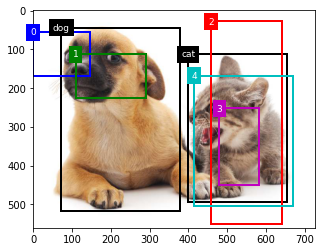

In [11]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])

anchors = torch.tensor([[0, 0.1, 0.2, 0.3],
                        [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], 
                        [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

fig = plt.imshow(img.squeeze(0).permute(1, 2, 0))

show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [12]:
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

In [13]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

给定一个锚框, 给定 offset 进行逆变换, 这样我们就能够通过偏移量来预测真实的边界线在哪

In [14]:
def offset_inverse(anchors, offset_preds):
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

使用非极大值抑制让明显重叠的边界框为 $0$, non-maximum suppression

In [15]:
def nms(boxes, scores, iou_threshold):
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []
    while B.numel() > 0: # B 里面的元素个数
        i = B[0]
        keep.append(i)
        if B.numel() == 1:
            break
        iou = box_iou(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1) # 大于 iou_threshold
        B = B[inds + 1] # 加一是因为前面计算 iou 的时候, box_iou 第二个变量是 [1:] 所以提前了一个, 这里要补回来
    return torch.tensor(keep, device=boxes.device)

In [16]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5, pos_threshold=0.009999999):
    # cls_probs 锚框对于不同类别的概率 shape (batch, num_classes, sample) 也就是一列是一个sample
    # offset_preds 锚框的偏移量 shape 
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2] # num_classes 是 背景 + 一共有多少类
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4) # offset_pred 锚框的偏移量
        conf, class_id = torch.max(cls_prob[1:], 0) # 每列取一个最大值, class_id 还是没有加一的类别
        predicted_bb = offset_inverse(anchors, offset_pred) # 通过偏移量和现有 anchor 预测真实的 bbox
        keep = nms(predicted_bb, conf, nms_threshold) # nms
        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx)) # 把 keep 的 index 和 所有的放一起
        uniques, counts = combined.unique(return_counts=True) # unitques 是 arange , counts是每个出现的次数
        non_keep = uniques[counts == 1] # 出现过一次的就是不要的
        all_id_sorted = torch.cat((keep, non_keep)) # 保留的在前面, 不要的在后面
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted] # 排了一下序, 保留的class放前面, 不要的在后面, 也就是 -1
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted] # 也是排一下序
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold) # 找到背景
        class_id[below_min_idx] = -1 #  设置背景为 -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1), conf.unsqueeze(1), predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [17]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

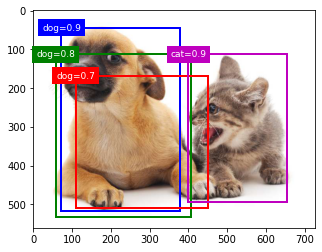

In [18]:
fig = d2l.plt.imshow(img.squeeze(0).permute(1, 2, 0))
show_bboxes(fig.axes, anchors*bbox_scale, ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [24]:
output = multibox_detection(cls_probs.unsqueeze(0), offset_preds.unsqueeze(0), anchors.unsqueeze(0), 0.5)
print('第一列id, 第二列是概率, 后面是bbox信息')
print(output)

第一列id, 第二列是概率, 后面是bbox信息
tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])


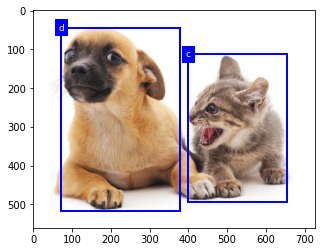

In [20]:
fig = d2l.plt.imshow(img.squeeze(0).permute(1, 2, 0))
for i in output[0].detach().numpy():
    if i[0] == -1: # -1 是背景
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)